# Topological Data Analysis (TDA) of PDGFR-β+ cells

Topological Data Analysis (TDA) is an approach to study the shape and structure of data, capturing features that might be missed by other techniques. Thus, TDA aims to understand the underlying space that the data inhabits.

With persistence homology, we can capture features that persist over various spatial or temporal scales, helping to distinguish between noise (short-lived features) and significant structures (long-lived features). Specifically, TDA is robust to small perturbations, ensuring consistent results even in the presence of noise or minor discrepancies. In this section, the aim is to apply topological techniques to the detected PDGFR-β+ cells in specific ROIs (perilesion, striatum and cortex).

## Load required libraries

In [1]:
import pandas as pd
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt
import os
import csv
from matplotlib.collections import LineCollection
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection
from gudhi import RipsComplex, plot_persistence_diagram
from ripser import ripser
from persim import plot_diagrams
import itertools
from random import choices
from gudhi import bottleneck_distance
import seaborn as sns
import matplotlib.pyplot as plt
from gudhi.wasserstein import wasserstein_distance


## Load and handle the dataset

We load the "Data_Raw\Widefield_20x_ROIs_Pdgfrb_Cells\Cells.csv" dataset containing the raw data obtained from cell detections in CellProfiller. We handle the data to obtain and organize the relevant metadata from the file name. 

In [ ]:
import pandas as pd

# Load the dataset
file_path = 'Data_Raw/Widefield_20x_ROIs_Pdgfrb_Cells/Cells.csv'  
data = pd.read_csv(file_path)

# Keep only the specified columns
data = data[['Location_Center_X', 'Location_Center_Y', 'FileName_Raw']]

# Define a function to parse the FileName_Raw column
def parse_filename(filename):
    parts = filename.split('_')
    # Extract the needed parts based on their position
    MouseID = parts[0]
    DPI = parts[1]
    Condition = parts[2]
    Lesion = parts[3]
    Region = parts[4]
    return MouseID, DPI, Condition, Lesion, Region

# Apply the function to the DataFrame
data[['MouseID', 'DPI', 'Condition', 'Lesion', 'Region']] = data.apply(lambda row: parse_filename(row['FileName_Raw']), axis=1, result_type='expand')

# Drop the FileName_Raw column
data.drop('FileName_Raw', axis=1, inplace=True)

# Reorder columns to move Location_Center_X and Location_Center_Y to the right
column_order = ['MouseID', 'DPI', 'Condition', 'Lesion', 'Region', 'Location_Center_X', 'Location_Center_Y']
data = data[column_order]

# Save the updated dataset to a new file
output_file_path = 'Data_Processed/Widefield_20x_ROIs_Pdgfrb_CellCoordinates.csv'  # Change this as needed
data.to_csv(output_file_path, index=False)

print("Dataset updated and saved to:", output_file_path)


## Calculate Vietoris-Rips Complex

DEFINITION

In [ ]:
# Load the organized dataset
data_path = 'Data_Processed/Widefield_20x_ROIs_Pdgfrb_TDA.csv'  # Adjust this path as necessary
data = pd.read_csv(data_path)

# Group the dataset by MouseID and Region, then extract the point clouds
point_clouds_by_mouse_region = data.groupby(['MouseID', 'DPI', 'Region']).apply(lambda df: df[['Location_Center_X', 'Location_Center_Y']].values).to_dict()


def calculate_vietoris_rips_complex(point_cloud, max_dim, max_radius):
    """
    Calculate the Vietoris-Rips complex for a given point cloud.
    
    Parameters:
    - point_cloud: numpy array of shape (n_points, n_dimensions) representing the point cloud.
    - max_dim: int, the maximal dimension of the simplices in the Vietoris-Rips complex.
    - max_radius: float, the maximal radius for simplices in the Vietoris-Rips complex.
    
    Returns:
    - simplex_tree: a GUDHI SimplexTree object representing the Vietoris-Rips complex.
    """
    rips_complex = gudhi.RipsComplex(points=point_cloud, max_edge_length=max_radius)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dim)
    return simplex_tree

# Parameters for Vietoris-Rips complex calculation
max_dim = 3
max_radius = 100

# Calculate Vietoris-Rips complexes for each region of each animal
vietoris_rips_complexes = {}
for (mouse_id, dpi, region), point_cloud in point_clouds_by_mouse_region.items():
    key = (mouse_id, dpi, region)  # Use a tuple of MouseID and Region as the key
    vietoris_rips_complexes[key] = calculate_vietoris_rips_complex(point_cloud, max_dim, max_radius)



### Visualize and save Vietoris-Rips Complex

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib.collections import LineCollection

def plot_vietoris_rips_complex(point_cloud, simplex_tree, filename, save_dir, x_range=None, y_range=None):
    """
    Plot and save the Vietoris-Rips complex for a given 2D point cloud, with specified x and y axis ranges.

    Parameters:
    - point_cloud: numpy array of shape (n_points, 2) representing the 2D point cloud.
    - simplex_tree: a gudhi object representing the Vietoris-Rips complex.
    - filename: str, the name of the file to save the image.
    - save_dir: str, directory to save the image.
    - x_range: tuple, the range for the x-axis (optional).
    - y_range: tuple, the range for the y-axis (optional).
    """
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Plot points
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], c='black', s=20, alpha=0.8)
    
    # Plot edges
    edges = []
    for simplex in simplex_tree.get_skeleton(2):  # Get up to 2-simplices (edges)
        if len(simplex[0]) == 2:  # Edges
            p1, p2 = point_cloud[simplex[0][0]], point_cloud[simplex[0][1]]
            edges.append([p1, p2])
    lc = LineCollection(edges, colors='green', linewidths=1, alpha=0.7)
    ax.add_collection(lc)
    
    # Adjust plot settings
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    if x_range is not None:
        ax.set_xlim(x_range)
    if y_range is not None:
        ax.set_ylim(y_range)
    
    plt.tight_layout()
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    plt.savefig(os.path.join(save_dir, f"{filename}.png"))
    plt.close()
    
    
# Directory to save the images
output_dir = "D:/Research/Stroke_PDGFR-B_Reactivity/Images/Widefield_20x-ROIs_Pdgfrb_TDA/VietorisRips_Static"  # Update this path
#x_range = (0, 2000)  # Example x-axis range
#y_range = (0, 1500)  # Example y-axis range
#aspect_ratio = 'auto'  # Adjust this based on your data or preferences


# Assuming vietoris_rips_complexes and point_clouds_by_mouse have been computed accordingly
for (mouse_id, dpi, region), simplex_tree in vietoris_rips_complexes.items():
    filename = f"{mouse_id}_{dpi}_{region}_VietorisRips"
    point_cloud = point_clouds_by_mouse_region[(mouse_id, dpi, region)]
    plot_vietoris_rips_complex(point_cloud, simplex_tree, filename, output_dir, x_range, y_range)


### Visualize and save Vietoris-Rips Complex (animated)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection
import numpy as np
import os

def animate_vietoris_rips_mp4(point_cloud, simplex_tree, filename, save_dir, max_radius, step_size=1):
    """
    Create an .mp4 animation illustrating the growth of the Vietoris-Rips complex for 2D data.
    """
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], c='black', s=20, alpha=0.8)

    # Function to update the plot for each frame
    def update(threshold):
        ax.cla()  # Clear current plot details
        ax.scatter(point_cloud[:, 0], point_cloud[:, 1], c='black', s=10, alpha=0.7)
        edges = []
        for simplex in simplex_tree.get_skeleton(2):
            if simplex[1] <= threshold:
                if len(simplex[0]) == 2:  # Edges
                    p1, p2 = point_cloud[simplex[0][0]], point_cloud[simplex[0][1]]
                    edges.append([p1, p2])
        lc = LineCollection(edges, colors='green', alpha=0.7)
        ax.add_collection(lc)
        
        ax.set_title(f"Threshold: {threshold:.2f}", fontsize=20)
        ax.set_xlabel('X', fontsize=20, labelpad=15)
        ax.set_ylabel('Y', fontsize=20, labelpad=15)
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.axis('equal')

    ani = FuncAnimation(fig, update, frames=np.arange(0, max_radius, step_size), blit=False)
    ani_file = os.path.join(save_dir, f"{filename}_Animation.mp4")
    ani.save(ani_file, writer='ffmpeg', fps=2)

    plt.close()
    return ani_file  # Return the file path of the saved animation

# Example usage
output_dir = "D:/Research/Stroke_PDGFR-B_Reactivity/Images/Widefield_20x-ROIs_Pdgfrb_TDA/VietorisRips_Animated"  # Update this path
max_radius = 200  # Adjust as necessary
step_size = 10  # Adjust as necessary

for (mouse_id, dpi, region), simplex_tree in vietoris_rips_complexes.items():
    filename = f"{mouse_id}_{dpi}_{region}_VietorisRips"
    point_cloud = point_clouds_by_mouse_region[(mouse_id, dpi, region)]
    ani_file = animate_vietoris_rips_mp4(point_cloud, simplex_tree, filename, output_dir, max_radius, step_size)
    print(f"Saved animation: {ani_file}")


## Calculate persistent homology (0D and 1D)

Now, we analize the point cloud using persisten homology. 

We use the same data the "process_and_visualize_persistence" function to process the same dataset containing xy coordinates of PDGFR+ cells. We compute persistent diagrams using the ripster libary. These diagrams capture the birth and death of topological features (like loops or voids) in the data as one varies a filtering parameter. The persistence diagrams are then visualized using the persim library. These visualizations provide insights into the topological structure of the data, indicating features that persist across scales. In TDA, features that persist longer (i.e., have a wider gap between birth and death) are deemed more significant as they represent genuine structures rather than noise.Each persistence diagram is saved as a .png image.

### Load data

We load the data set in case is not present in the enviroment

In [ ]:
# Load your dataset
data_path = 'Data_Processed/Widefield_20x_ROIs_Pdgfrb_CellCoordinates.csv'  # Update this to the path of your CSV
data = pd.read_csv(data_path)

# Group data by MouseID, Region, and DPI
point_clouds_by_group = data.groupby(['MouseID', 'DPI', 'Region',]).apply(
    lambda df: df[['Location_Center_X', 'Location_Center_Y']].values
).to_dict()

We verify the data:    

In [ ]:
if not point_clouds_by_group:
    print("The point_clouds_by_group dictionary is empty.")
else:
    print("Point clouds loaded:", len(point_clouds_by_group))
    
    # Inspect the first few items to ensure they're structured correctly
for key, value in list(point_clouds_by_group.items())[:5]:
    print(key, value.shape)

### Save the data as point clouds

We save the point clouds as .npy files to facilitate the computation of persisten homology.

In [ ]:
def save_point_clouds_as_npy(point_clouds_by_group, data_directory):
    """
    Saves point clouds to .npy files in the specified directory.
    
    Parameters:
        point_clouds_by_group (dict): Dictionary with keys as identifiers 
            (e.g., ('MouseID', 'Region', 'DPI')) and values as numpy arrays representing point clouds.
        data_directory (str): Path to the directory where .npy files will be saved.
    """
    # Ensure the directory exists
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)
    
    # Iterate through the point clouds and save each as an .npy file
    for identifier, point_cloud in point_clouds_by_group.items():
        # Create a filename from the identifier
        filename = "_".join(identifier) + ".npy"
        filepath = os.path.join(data_directory, filename)
        np.save(filepath, point_cloud)
    
    print("Point clouds saved as .npy files.")

data_directory = r"D:/Research/Stroke_PDGFR-B_Reactivity/Pdgfrb_Reactivity_DataAnalysis/Stroke_Pdgfrb_Reactivity/Data_Raw/Widefield_20x_ROIs_Pdgfrb/PointClouds"

# Call the function with your data and desired save location
save_point_clouds_as_npy(point_clouds_by_group, data_directory)


### Compute persistence diagrams

We compute persistence diagrams and save then as .npy file for further analysis and as .png images for visualization

In [ ]:
# Disable LaTeX usage in matplotlib
plt.rcParams['text.usetex'] = False

def process_npy_for_persistence_diagrams(data_directory, save_directory, save_diag_directory, img_size=(6, 6)):
    """
    Batch process .npy files (containing point clouds) to compute, visualize, and save persistence diagrams.
    """
    # Ensure save directories exist
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    if not os.path.exists(save_diag_directory):
        os.makedirs(save_diag_directory)
    
    # List all .npy files in the data directory
    npy_files = [f for f in os.listdir(data_directory) if f.endswith('.npy')]
    
    for file in npy_files:
        # Load the point cloud from the .npy file
        points_array = np.load(os.path.join(data_directory, file))
        
        # Compute the persistence diagrams using Ripser
        diagrams = ripser(points_array, maxdim=1)['dgms']
        
        # Save each dimension's persistence diagram as a separate .npy file
        for dim, diag in enumerate(diagrams):
            diag_filename = os.path.splitext(file)[0] + f"_persistence_diag_dim{dim}.npy"
            np.save(os.path.join(save_diag_directory, diag_filename), diag)
        
        # Visualize and save the persistence diagrams
        fig, ax = plt.subplots(figsize=img_size)
        plot_diagrams(diagrams, show=False, ax=ax)
        ax.set_title("")
        ax.set_xlabel('Birth', fontsize=25)
        ax.set_ylabel('Death', fontsize=25)
        ax.tick_params(axis='both', which='major', labelsize=25)
        
        # Optionally adjust the legend
        legend = ax.legend()
        if legend:
            for label in legend.get_texts():
                label.set_fontsize(20)
        
        plt.tight_layout()
        
        if x_range is not None:
            ax.set_xlim(x_range)
        if y_range is not None:
            ax.set_ylim(y_range)
        
        # Save the figure
        filename = os.path.splitext(file)[0] + "_persistence_diagram.png"
        fig.savefig(os.path.join(save_directory, filename))
        plt.close()
    
    print(f"Persistence diagrams saved to {save_directory}.")
    print(f"Persistence diagrams data saved to {save_diag_directory}.")

# Paths to your directories
data_directory = r"D:/Research/Stroke_PDGFR-B_Reactivity/Pdgfrb_Reactivity_DataAnalysis/Stroke_Pdgfrb_Reactivity/Data_Raw/Widefield_20x_ROIs_Pdgfrb/PointClouds/"
save_directory = r"D:/Research/Stroke_PDGFR-B_Reactivity/Images/Widefield_20x-ROIs_Pdgfrb_TDA/PersistenceDiagrams"
save_diag_directory = r"D:/Research/Stroke_PDGFR-B_Reactivity/Pdgfrb_Reactivity_DataAnalysis/Stroke_Pdgfrb_Reactivity/Data_Raw/Widefield_20x_ROIs_Pdgfrb/PersistenceDiagrams/"

x_range = (0, 500)  # Example x-axis range
y_range = (0, 5000)  # Example y-axis range

# Call the function to process, visualize, and save persistence diagrams
process_npy_for_persistence_diagrams(data_directory, save_directory, save_diag_directory)


## Calculate Bottleneck distances

Comparing persistent diagrams is crucial when we want to measure the difference between two topological spaces. Here, we use the bottleneck distance for this purpose. Given two persistence diagrams D1 and D2, the bottleneck distance measures the minimum amount one needs to move points in D1 to match points in D2 and vice versa, such that the worst-case (or maximum) movement is minimized. Mathematically, the bottleneck distance is defined as:

$$
\text{bottleneck}(D_1, D_2) = \inf_{\phi: D_1 \to D_2} \sup_{x \in D_1} ||x - \phi(x)||_{\infty}
$$

The, with bootstrapping, we estimate the distribution of the bottleneck distances by resampling with replacement from the data. 
Then, we repeat the sampling 1000 times to compute 95% confidence intervals.


In our analysis, we load organize persistence diagrams corresponding to various days, regions, and proteins from designated file paths. The diagrams are gouped based on the mentioned factors and perform specific pairwise day comparisons. We use bootstrap iterations to obtain bottleneck distances between the persistence diagrams of two distinct days, representing the topological disparity between them. These results are stored in a CSV file and the visualized as a heat map.

### Load persistance diagrams

In this chunk, we are setting up the environment for subsequent analysis by performing the following steps:

1. Define the path where the persistence diagrams are stored.
2. List all files in the defined path that have the filename ending with 'dim0.npy'. This implies we are focusing on dimension 0 persistence diagrams.

Then, for each file:
1. Extract day, region, and protein information from the filename.
2. Load the persistence diagram from the file using numpy.
3. Store the extracted information and loaded data in the data list.

Note: To shift focus to dimension 1 persistence diagrams, one can replace 'dim0.npy' with 'dim1.npy' in the code.

In [ ]:
### To calculate dimension 1, change the dim0 to dim1

# Define the path to persistence diagrams
path = "D:/Research/Stroke_PDGFR-B_Reactivity/Pdgfrb_Reactivity_DataAnalysis/Stroke_Pdgfrb_Reactivity/Data_Raw/Widefield_20x_ROIs_Pdgfrb/PersistenceDiagrams/"

# Load .npy files for dimension 1 diagrams
files = [f for f in os.listdir(path) if f.endswith('dim1.npy')]

# Organize data into a nested dictionary {day: {region: [diagrams, ...], ...}, ...}
data = {}
for file in files:
    # Extract information from the filename
    parts = file.split("_")
    day, region = parts[1], parts[2]
    # Load the persistence diagram
    diagram = np.load(os.path.join(path, file))
    # Initialize day if not already in data
    if day not in data:
        data[day] = {}
    # Append the diagram to the correct day and region
    data[day].setdefault(region, []).append(diagram)

Next, we verifying the loaded data structure

In [ ]:

for day in data:
    print(f"Day: {day}")
    for region in data[day]:
        num_diagrams = len(data[day][region])
        print(f"  Region: {region}, Number of diagrams: {num_diagrams}")
        # Optionally, print out some details of the first diagram as an example
        if num_diagrams > 0:
            example_diagram = data[day][region][0]
            print(f"    Example diagram size: {example_diagram.shape}")
            print(f"    Example diagram content (first few pairs): {example_diagram[:5]}")
        else:
            print("    No diagrams for this region and day.")
    print("\n")  # Add a newline for better readability between days



### Computing distances by boostraping and saving metrics

Now it's time to conduct the bootstrapping analysis on bottleneck distances. We perform the analysis between persistence diagrams for specified pairwise day comparisons.Firts, we define the specific pairwise day comparisons of interest (0D-3D, 3D-7D, 7D-14D, 14D-30D) and extract unique days, regions, and proteins from the data. Thereafter:

1. Initialize an empty list, results, to store the analysis outcome.
2. Define the number of bootstrap replications (num_replications) as 1000.

For each unique combination of Region and Protein, we extract persistence diagrams associated with each day. The region Peri (Perilesional) does not contain information from 0D. Therefore, we skip to the next iteration.

To perform the bootstrap procedure:

1. Randomly sample persistence diagrams from both days with replacement.
2. Compute pairwise bottleneck distances for these bootstrap samples.
3. Calculate the **median** bottleneck distance for this bootstrap replication.
4. Compute the median bottleneck distance across all replications and calculate the 95% confidence interval.

Finally, we store the results in the results list as a .csv file. The table have headers 'Day1', 'Day2', 'Region', 'Protein', 'Median Bottleneck Distance', '95% CI Lower', and '95% CI Upper'. Each row corresponds to the computed results for a given pairwise day comparison, region, and protein combination.

In [ ]:
# Define the specified pairwise day comparisons
day_pairs = [("0D", "3D"), ("3D", "7D"), ("7D", "14D"), ("14D", "30D")]

# Extract unique days and regions from the data
unique_days = set(data.keys())
unique_regions = set(region for day in data for region in data[day])

results = []

# Define number of bootstrap replications
num_replications = 1000

# For each unique combination of Day and Region
for region in unique_regions:
    # Perform the specified pairwise comparison of diagrams from different days
    for day1, day2 in day_pairs:
        bootstrap_distances = []

        for _ in range(num_replications):
            # Randomly sample diagrams from day1 and day2 with replacement
            bootstrap_sample1 = choices(data[day1].get(region, []), k=len(data[day1].get(region, [])))
            bootstrap_sample2 = choices(data[day2].get(region, []), k=len(data[day2].get(region, [])))

            # Compute pairwise bottleneck distances for the bootstrap samples
            distances = [bottleneck_distance(diag1, diag2) for diag1 in bootstrap_sample1 for diag2 in bootstrap_sample2 if diag1.size and diag2.size]

            # Only proceed if there are distances to calculate
            if distances:
                # Compute the median distance for this bootstrap replication
                bootstrap_distances.append(np.median(distances))

        # Skip if no distances were calculated
        if not bootstrap_distances:
            continue

        # Compute metrics
        median_distance = np.median(bootstrap_distances)
        confidence_lower = np.percentile(bootstrap_distances, 2.5)
        confidence_upper = np.percentile(bootstrap_distances, 97.5)

        # Store the results
        results.append((day1, day2, region, median_distance, confidence_lower, confidence_upper))

# Define the results path and save results to CSV
results_path = "D:/Research/Stroke_PDGFR-B_Reactivity/Pdgfrb_Reactivity_DataAnalysis/Stroke_Pdgfrb_Reactivity/Data_Raw/Widefield_20x_ROIs_Pdgfrb/"

# Change the name for 1D
csv_file = os.path.join(results_path, "Widefield_20x_ROIs_Pdgfrb_Bottleneck_0d.csv")

with open(csv_file, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    # Write header
    csvwriter.writerow(['Day1', 'Day2', 'Region', 'Median Bottleneck Distance', '95% CI Lower', '95% CI Upper'])
    # Write the results
    for row in results:
        csvwriter.writerow(row)

print(f"Bootstrap results saved to {csv_file}.")


### Visualization of bottleneck distances by heatmap

We vislauzie the bottleneck distances by heatmap using seaborn:

In [ ]:
# Load CSV data for 0-dimension and 1-dimension homology
csv_path_dim0 = os.path.join(csv_path, "D:/Research/Stroke_PDGFR-B_Reactivity/Pdgfrb_Reactivity_DataAnalysis/Stroke_Pdgfrb_Reactivity/Data_Raw/Widefield_20x_ROIs_Pdgfrb/Widefield_20x_ROIs_Pdgfrb_Bottleneck_0d.csv")
csv_path_dim1 = os.path.join(csv_path, "D:/Research/Stroke_PDGFR-B_Reactivity/Pdgfrb_Reactivity_DataAnalysis/Stroke_Pdgfrb_Reactivity/Data_Raw/Widefield_20x_ROIs_Pdgfrb/Widefield_20x_ROIs_Pdgfrb_Bottleneck_1d.csv")
data_dim0 = pd.read_csv(csv_path_dim0)
data_dim1 = pd.read_csv(csv_path_dim1)

# Assuming the structure of your CSV files matches the expected columns

# Define label mappings and structure
regions = ["Peri", "Str", "Ctx"]
region_labels = ["Perilesion", "Striatum", "Cortex"]
days = ["0D-3D", "3D-7D", "7D-14D", "14D-30D"]
dimensions = ["dim0", "dim1"]  # Representing 0-dimension and 1-dimension homology

# Initialize an empty dictionary to store heatmap data for each dimension
heatmap_data = {dim: pd.DataFrame(index=regions, columns=days) for dim in dimensions}
heatmap_annotations = {dim: pd.DataFrame(index=regions, columns=days) for dim in dimensions}

# Function to populate matrices with data from CSV
def populate_heatmap(data, dim):
    for _, row in data.iterrows():
        day_pair, region, median_distance, lower, upper = row['Day1']+'-'+row['Day2'], row['Region'], round(row['Median Bottleneck Distance']), round(row['95% CI Lower']), round(row['95% CI Upper'])
        if region in regions:
            heatmap_data[dim].loc[region, day_pair] = median_distance
            # Adjust annotation format here to round and remove decimals
            annotation = f"{median_distance}\n({lower} - {upper})"
            heatmap_annotations[dim].loc[region, day_pair] = annotation

populate_heatmap(data_dim0, "dim0")
populate_heatmap(data_dim1, "dim1")

# Convert the data to numeric and handle NaN values
for dim in dimensions:
    heatmap_data[dim] = heatmap_data[dim].astype(float)
    heatmap_data[dim].fillna(-1, inplace=True)  # Fill NaN values with -1 for missing data

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
for ax, dim in zip(axes, dimensions):
    sns.heatmap(heatmap_data[dim], annot=heatmap_annotations[dim], cmap='viridis', ax=ax,
                cbar_kws={'label': 'Bottleneck Distance', 'shrink': 0.5},
                mask=(heatmap_data[dim] == -1), fmt="", annot_kws={"size": 16})
    ax.set_title(f"Dimension: {dim[-1]}", fontsize=16)
    ax.set_xlabel("Day Pair", fontsize=16)
    ax.set_ylabel("Region", fontsize=16)
    ax.set_yticklabels(region_labels, fontsize=16, rotation=0)
    ax.tick_params(axis='x', labelsize=16)

    # Adjust colorbar label size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.set_ylabel('Bottleneck Distance', fontsize=16)

plt.tight_layout()
plt.show()

# Update the output directory path for saving individual images
output_dir = "D:/Research/Stroke_PDGFR-B_Reactivity/Pdgfrb_Reactivity_DataAnalysis/Stroke_Pdgfrb_Reactivity/Plots/Widefield_20x_ROIs_pdgfrb_TDA"

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save individual heatmap images for each dimension
for dim in dimensions:
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.heatmap(heatmap_data[dim], annot=heatmap_annotations[dim], cmap='viridis', ax=ax,
                cbar_kws={'label': 'Bottleneck Distance'},
                mask=(heatmap_data[dim] == -1), fmt="s")
    ax.set_title(f"Bottleneck Distances (Dimension: {dim[-1]})", fontsize=16)
    ax.set_xlabel("Day Pair", fontsize=16)
    ax.set_ylabel("Region", fontsize=16)
    ax.set_yticklabels(region_labels, fontsize=16)
    ax.tick_params(axis='x', labelsize=16)
    
    # Adjust colorbar label size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.set_ylabel('Bottleneck Distance', fontsize=16)
    
    plt.tight_layout()

    # Save the figure
    fig.savefig(os.path.join(output_dir, f"Bottleneck_Heatmap_{dim}.png"))
    plt.close(fig)


## Calculate Wasserstain distances

On the other hand, the Wasserstein Distance, often referred to as the Earth Mover's or Kantorovich-Rubinstein distance, offers a more intricate comparison. It contemplates all possible pairs of points between the two diagrams and weighs them by their distance. One can think of the Wasserstein distance as quantifying the minimum "effort" or "cost" to transform one persistence diagram into another. This "cost" embodies the amount of "work" essential to shift each point to its respective match in the other diagram. By accounting for both dominant and subtle features, the Wasserstein distance delivers a comprehensive measure of similarity.

These couple of tools allow us to contrast topological intricacies across the different experimental groups and brain areas.

### Load persistance diagrams

Load the data from the Bottleneck distances section. Please make sure to change dim0 or dim1 as needed. 

### Compute Wasserstein distances by boostrapping and saving metrics

In [ ]:
# Define the specified pairwise day comparisons
day_pairs = [("0D", "3D"), ("3D", "7D"), ("7D", "14D"), ("14D", "30D")]

# Extract unique days and regions from the data
unique_days = set(data.keys())
unique_regions = set(region for day in data for region in data[day])

results = []

# Define number of bootstrap replications
num_replications = 1000

# For each unique combination of Day and Region
for region in unique_regions:
    # Perform the specified pairwise comparison of diagrams from different days
    for day1, day2 in day_pairs:
        if day1 in data and day2 in data and region in data[day1] and region in data[day2]:
            bootstrap_distances = []

            for _ in range(num_replications):
                # Randomly sample diagrams from day1 and day2 with replacement
                bootstrap_sample1 = choices(data[day1].get(region, []), k=len(data[day1].get(region, [])))
                bootstrap_sample2 = choices(data[day2].get(region, []), k=len(data[day2].get(region, [])))

                # Compute pairwise Wasserstein distances for the bootstrap samples
                distances = [wasserstein_distance(diag1, diag2, order=2) for diag1 in bootstrap_sample1 for diag2 in bootstrap_sample2 if diag1.size and diag2.size]

                # Only proceed if there are distances to calculate
                if distances:
                    # Compute the median distance for this bootstrap replication
                    bootstrap_distances.append(np.median(distances))

            # Skip if no distances were calculated
            if not bootstrap_distances:
                continue

            # Compute metrics
            median_distance = np.median(bootstrap_distances)
            confidence_lower = np.percentile(bootstrap_distances, 2.5)
            confidence_upper = np.percentile(bootstrap_distances, 97.5)

            # Store the results
            results.append((day1, day2, region, median_distance, confidence_lower, confidence_upper))

# Define the results path and save results to CSV
results_path = "D:/Research/Stroke_PDGFR-B_Reactivity/Pdgfrb_Reactivity_DataAnalysis/Stroke_Pdgfrb_Reactivity/Data_Raw/Widefield_20x_ROIs_Pdgfrb/"
csv_file = os.path.join(results_path, "Widefield_20x_ROIs_Pdgfrb_Wasserstein_1d.csv")

with open(csv_file, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    # Write header
    csvwriter.writerow(['Day1', 'Day2', 'Region', 'Median Wasserstein Distance', '95% CI Lower', '95% CI Upper'])
    # Write the results
    for row in results:
        csvwriter.writerow(row)

print(f"Wasserstein distance bootstrap results saved to {csv_file}.")


###  Visualization of Wasserstein distances by heatmap

In [ ]:
# Load CSV data for 0-dimension and 1-dimension homology
csv_path_dim0 = os.path.join("D:/Research/Stroke_PDGFR-B_Reactivity/Pdgfrb_Reactivity_DataAnalysis/Stroke_Pdgfrb_Reactivity/Data_Raw/Widefield_20x_ROIs_Pdgfrb/Widefield_20x_ROIs_Pdgfrb_Wasserstein_0d.csv")
csv_path_dim1 = os.path.join("D:/Research/Stroke_PDGFR-B_Reactivity/Pdgfrb_Reactivity_DataAnalysis/Stroke_Pdgfrb_Reactivity/Data_Raw/Widefield_20x_ROIs_Pdgfrb/Widefield_20x_ROIs_Pdgfrb_Wasserstein_1d.csv")
data_dim0 = pd.read_csv(csv_path_dim0)
data_dim1 = pd.read_csv(csv_path_dim1)

# Assuming the structure of your CSV files matches the expected columns

# Define label mappings and structure
regions = ["Peri", "Str", "Ctx"]
region_labels = ["Perilesion", "Striatum", "Cortex"]
days = ["0D-3D", "3D-7D", "7D-14D", "14D-30D"]
dimensions = ["dim0", "dim1"]  # Representing 0-dimension and 1-dimension homology

# Initialize an empty dictionary to store heatmap data for each dimension
heatmap_data = {dim: pd.DataFrame(index=regions, columns=days) for dim in dimensions}
heatmap_annotations = {dim: pd.DataFrame(index=regions, columns=days) for dim in dimensions}

# Function to populate matrices with data from CSV
def populate_heatmap(data, dim):
    for _, row in data.iterrows():
        day_pair, region, median_distance, lower, upper = row['Day1']+'-'+row['Day2'], row['Region'], round(row['Median Wasserstein Distance']), round(row['95% CI Lower']), round(row['95% CI Upper'])
        if region in regions:
            heatmap_data[dim].loc[region, day_pair] = median_distance
            # Adjust annotation format here to round and remove decimals
            annotation = f"{median_distance}\n({lower} - {upper})"
            heatmap_annotations[dim].loc[region, day_pair] = annotation

populate_heatmap(data_dim0, "dim0")
populate_heatmap(data_dim1, "dim1")

# Convert the data to numeric and handle NaN values
for dim in dimensions:
    heatmap_data[dim] = heatmap_data[dim].astype(float)
    heatmap_data[dim].fillna(-1, inplace=True)  # Fill NaN values with -1 for missing data

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
for ax, dim in zip(axes, dimensions):
    sns.heatmap(heatmap_data[dim], annot=heatmap_annotations[dim], cmap='viridis', ax=ax,
                cbar_kws={'label': 'Wasserstein Distance', 'shrink': 0.5},
                mask=(heatmap_data[dim] == -1), fmt="", annot_kws={"size": 16})
    ax.set_title(f"Dimension: {dim[-1]}", fontsize=16)
    ax.set_xlabel("Day Pair", fontsize=16)
    ax.set_ylabel("Region", fontsize=16)
    ax.set_yticklabels(region_labels, fontsize=16, rotation=0)
    ax.tick_params(axis='x', labelsize=16)

    # Adjust colorbar label size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.set_ylabel('Wasserstein Distance', fontsize=16)

plt.tight_layout()
plt.show()

# Update the output directory path for saving individual images
output_dir = "D:/Research/Stroke_PDGFR-B_Reactivity/Pdgfrb_Reactivity_DataAnalysis/Stroke_Pdgfrb_Reactivity/Plots/Widefield_20x_ROIs_pdgfrb_TDA"

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save individual heatmap images for each dimension
for dim in dimensions:
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.heatmap(heatmap_data[dim], annot=heatmap_annotations[dim], cmap='viridis', ax=ax,
                cbar_kws={'label': 'Wasserstein Distance'},
                mask=(heatmap_data[dim] == -1), fmt="s")
    ax.set_title(f"Wasserstein Distances (Dimension: {dim[-1]})", fontsize=16)
    ax.set_xlabel("Day Pair", fontsize=16)
    ax.set_ylabel("Region", fontsize=16)
    ax.set_yticklabels(region_labels, fontsize=16)
    ax.tick_params(axis='x', labelsize=16)
    
    # Adjust colorbar label size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.set_ylabel('Wasserstein Distance', fontsize=16)
    
    plt.tight_layout()

    # Save the figure
    fig.savefig(os.path.join(output_dir, f"Wasserstein_Heatmap_{dim}.png"))
    plt.close(fig)


## Calculate betti curves

### Compute the betti curves for0-d homolgy

We need to compute for 0D and 1D separetely to avoid errors. 

#### Load persistence diagrams for 0-d homology

In [11]:
def load_persistence_diagrams(dim0_path):
    files = [f for f in os.listdir(dim0_path) if 'dim0' in f]
    data = {}
    for file in files:
        parts = file.split('_')
        day, region = parts[1], parts[2]
        diagram = np.load(os.path.join(dim0_path, file))
        key = (day, region)
        data[key] = diagram
    return data

dim0_path = "D:/Research/Stroke_PDGFR-B_Reactivity/Pdgfrb_Reactivity_DataAnalysis/Stroke_Pdgfrb_Reactivity/Data_Raw/Widefield_20x_ROIs_Pdgfrb/PersistenceDiagrams/"
dim0_data = load_persistence_diagrams(dim0_path)


We first define the function to calculate the betti curve

In [12]:
def compute_betti_0_curve(persistence_diagram, max_filtration_value, n_steps):
    betti_0_curve = []
    filtration_values = np.linspace(0, max_filtration_value, n_steps)
    for value in filtration_values:
        betti_0 = sum(1 for point in persistence_diagram if point[0] <= value and (point[1] > value or point[1] == float('inf')))
        betti_0_curve.append(betti_0)
    return betti_0_curve

n_steps = 100
max_filtration_value = 200
betti_0_curves = {key: compute_betti_0_curve(diagram, max_filtration_value, n_steps) for key, diagram in dim0_data.items()}



We visuaize the results

In [13]:
# Aggregating Betti curves by region
aggregated_curves_by_region_0 = {}
for (day, region), curve in betti_0_curves.items():
    if region not in aggregated_curves_by_region_0:
        aggregated_curves_by_region_0[region] = {}
    aggregated_curves_by_region_0[region][day] = curve  


Saved Betti-0 curve plot for Ctx at D:/Research/Stroke_PDGFR-B_Reactivity/Pdgfrb_Reactivity_DataAnalysis/Stroke_Pdgfrb_Reactivity/Plots/Widefield_20x_ROIs_pdgfrb_TDA\Betti0_Curves_Ctx.png


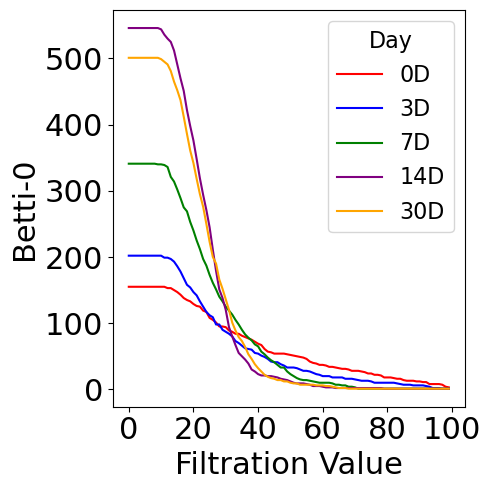

Saved Betti-0 curve plot for Peri at D:/Research/Stroke_PDGFR-B_Reactivity/Pdgfrb_Reactivity_DataAnalysis/Stroke_Pdgfrb_Reactivity/Plots/Widefield_20x_ROIs_pdgfrb_TDA\Betti0_Curves_Peri.png


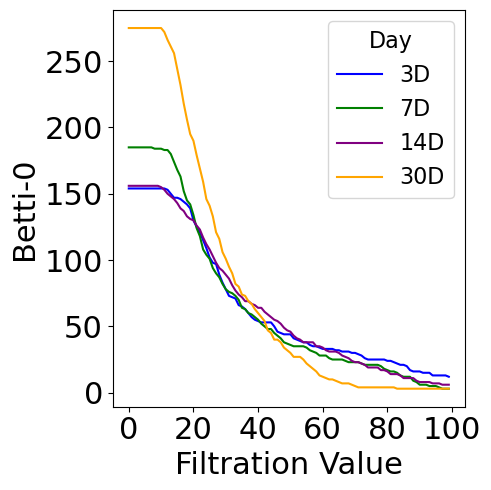

Saved Betti-0 curve plot for Str at D:/Research/Stroke_PDGFR-B_Reactivity/Pdgfrb_Reactivity_DataAnalysis/Stroke_Pdgfrb_Reactivity/Plots/Widefield_20x_ROIs_pdgfrb_TDA\Betti0_Curves_Str.png


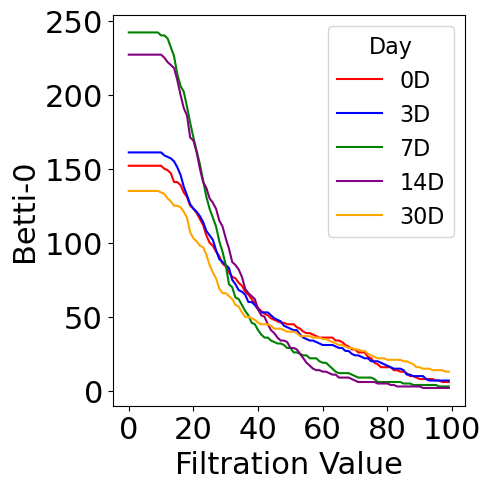

In [25]:
def plot_aggregated_betti_curves_0(aggregated_curves_by_region_0, save_directory):
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    
    days_order = ['0D', '3D', '7D', '14D', '30D']
    day_colors = {
        '0D': 'red',
        '3D': 'blue',
        '7D': 'green',
        '14D': 'purple',
        '30D': 'orange'
    }

    for region, curves in aggregated_curves_by_region_0.items():
        plt.figure(figsize=(5, 5))  # Adjust figure size as needed
        for day in days_order:
            if day in curves:
                plt.plot(curves[day], label=day, color=day_colors[day])
        
        plt.xlabel("Filtration Value", fontsize=22)
        plt.ylabel("Betti-0", fontsize=22)
        plt.xticks(fontsize=22)  # Increase tick label size
        plt.yticks(fontsize=22)  # Increase tick label size
        leg = plt.legend(title="Day", fontsize=16)
        plt.setp(leg.get_title(), fontsize=16)  # Increase legend title size
        plt.tight_layout()

        # Save the plot before calling plt.show()
        plot_path = os.path.join(save_directory, f"Betti0_Curves_{region}.png")
        plt.savefig(plot_path)
        print(f"Saved Betti-0 curve plot for {region} at {plot_path}")
        
        # Show the plot inline
        plt.show()
        plt.close()

# Specify the directory where you want to save the plots
save_directory = "D:/Research/Stroke_PDGFR-B_Reactivity/Pdgfrb_Reactivity_DataAnalysis/Stroke_Pdgfrb_Reactivity/Plots/Widefield_20x_ROIs_pdgfrb_TDA"

# Call the function with your aggregated Betti curves and the save directory
plot_aggregated_betti_curves_0(aggregated_curves_by_region_0, save_directory)


    


#### Compute betti curves for 1d homology

We load persistance diagrams for 1d homology

In [16]:
def load_persistence_diagrams(dim1_path):
    files = [f for f in os.listdir(dim1_path) if 'dim1' in f]
    data = {}
    for file in files:
        parts = file.split('_')
        day, region = parts[1], parts[2]
        diagram = np.load(os.path.join(dim1_path, file))
        key = (day, region)
        data[key] = diagram
    return data

dim1_path = "D:/Research/Stroke_PDGFR-B_Reactivity/Pdgfrb_Reactivity_DataAnalysis/Stroke_Pdgfrb_Reactivity/Data_Raw/Widefield_20x_ROIs_Pdgfrb/PersistenceDiagrams/"
dim1_data = load_persistence_diagrams(dim1_path)


In [17]:
def compute_betti_1_curve(persistence_diagram, max_filtration_value, n_steps):
    betti_1_curve = []
    filtration_values = np.linspace(0, max_filtration_value, n_steps)
    for value in filtration_values:
        betti_1 = sum(1 for point in persistence_diagram if point[0] <= value and (point[1] > value or point[1] == float('inf')))
        betti_1_curve.append(betti_1)
    return betti_1_curve

n_steps = 100
max_filtration_value = 700
betti_1_curves = {key: compute_betti_1_curve(diagram, max_filtration_value, n_steps) for key, diagram in dim1_data.items()}


In [18]:
# Aggregating Betti curves by region
aggregated_curves_by_region_1 = {}
for (day, region), curve in betti_1_curves.items():
    if region not in aggregated_curves_by_region_1:
        aggregated_curves_by_region_1[region] = {}
    aggregated_curves_by_region_1[region][day] = curve

Saved Betti-1 curve plot for Ctx at D:/Research/Stroke_PDGFR-B_Reactivity/Pdgfrb_Reactivity_DataAnalysis/Stroke_Pdgfrb_Reactivity/Plots/Widefield_20x_ROIs_pdgfrb_TDA\Betti1_Curves_Ctx.png


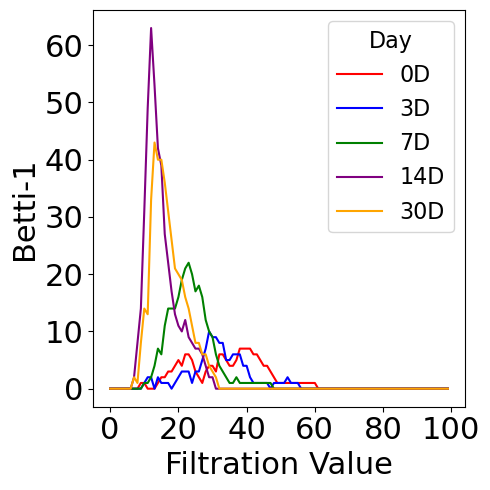

Saved Betti-1 curve plot for Peri at D:/Research/Stroke_PDGFR-B_Reactivity/Pdgfrb_Reactivity_DataAnalysis/Stroke_Pdgfrb_Reactivity/Plots/Widefield_20x_ROIs_pdgfrb_TDA\Betti1_Curves_Peri.png


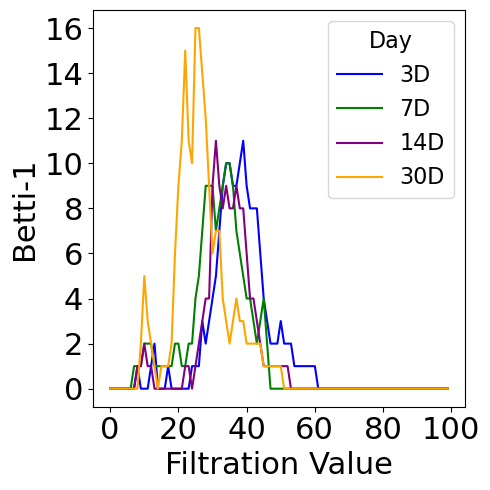

Saved Betti-1 curve plot for Str at D:/Research/Stroke_PDGFR-B_Reactivity/Pdgfrb_Reactivity_DataAnalysis/Stroke_Pdgfrb_Reactivity/Plots/Widefield_20x_ROIs_pdgfrb_TDA\Betti1_Curves_Str.png


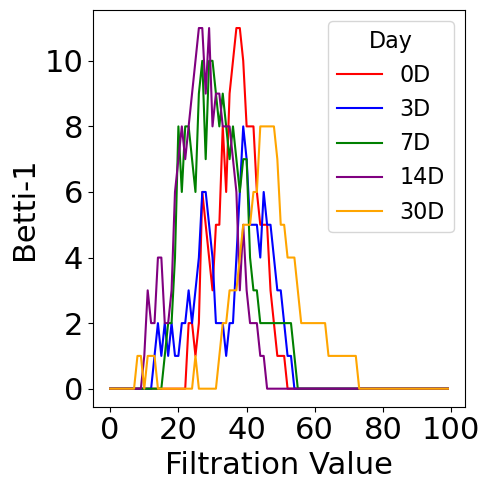

In [24]:
def plot_aggregated_betti_curves_1(aggregated_curves_by_region_1, save_directory):
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    
    days_order = ['0D', '3D', '7D', '14D', '30D']
    day_colors = {
        '0D': 'red',
        '3D': 'blue',
        '7D': 'green',
        '14D': 'purple',
        '30D': 'orange'
    }

    for region, curves in aggregated_curves_by_region_1.items():
        plt.figure(figsize=(5, 5))  # Adjust figure size as needed
        for day in days_order:
            if day in curves:
                plt.plot(curves[day], label=day, color=day_colors[day])
        
        plt.xlabel("Filtration Value", fontsize=22)
        plt.ylabel("Betti-1", fontsize=22)
        plt.xticks(fontsize=22)  # Increase tick label size
        plt.yticks(fontsize=22)  # Increase tick label size
        leg = plt.legend(title="Day", fontsize=16)
        plt.setp(leg.get_title(), fontsize=16)  # Increase legend title size
        plt.tight_layout()

        # Save the plot before calling plt.show()
        plot_path = os.path.join(save_directory, f"Betti1_Curves_{region}.png")
        plt.savefig(plot_path)
        print(f"Saved Betti-1 curve plot for {region} at {plot_path}")
        
        # Show the plot inline
        plt.show()
        plt.close()

# Specify the directory where you want to save the plots
save_directory = "D:/Research/Stroke_PDGFR-B_Reactivity/Pdgfrb_Reactivity_DataAnalysis/Stroke_Pdgfrb_Reactivity/Plots/Widefield_20x_ROIs_pdgfrb_TDA"

# Call the function with your aggregated Betti curves and the save directory
plot_aggregated_betti_curves_1(aggregated_curves_by_region_1, save_directory)